In [1]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as colors
from static_probabilities import TRANSITION_PROBABILITIES_12UL, EMISSION_PROBABILITIES_12UL, START_PROBABILITIES_12UL
from time import time
from collections import Counter

In [2]:
def plot_matrix(matrix):
    plt.imshow(matrix, interpolation='none', cmap=colormaps["autumn"], norm=colors.PowerNorm(0.1))
    for (j,i),label in np.ndenumerate(matrix):
        plt.text(i,j,round(label, 3),ha='center',va='center')
    plt.show()

In [3]:
from requests import get as _get
from os.path import isfile
import json

TELRAAM_URL = 'http://localhost:8080'

# Fetch data from cache or Telraam
def get(url: str) -> list:
    l = None
    if isfile(f"data/{url}.json"):
        with open(f"data/{url}.json", "r") as file:
            l = json.loads(file.read())
    else:
        l = _get(f'{TELRAAM_URL}/{url}').json()
        with open(f"data/{url}.json", "w") as file:
            file.write(json.dumps(l))
    
    print(l[0])
    print(f'Fetched {len(l)} items')
    return l

In [4]:
detections = sorted(get('detection'), key=lambda x: x["timestamp"])

{'id': 479017, 'batonId': 15, 'stationId': 9, 'rssi': -95, 'battery': 92.0, 'uptimeMs': 554087, 'remoteId': 1, 'timestamp': 1650975012000}
Fetched 2401946 items


In [5]:
batons = get('baton')

{'id': 2, 'name': 'O', 'mac': '5a:45:55:53:00:00'}
Fetched 22 items


In [6]:
baton_switchovers = sorted(get('batonswitchover'), key=lambda x: x["timestamp"])

{'id': 1, 'teamId': 1, 'previousBatonId': None, 'newBatonId': 23, 'timestamp': 1651012254359}
Fetched 73 items


In [7]:
stations = sorted(get('station'), key=lambda x: x["id"])

{'id': 2, 'name': 'station 1', 'distanceFromStart': 11.0, 'isBroken': False, 'url': 'http://172.12.50.101:8000'}
Fetched 7 items


In [8]:
teams = get('team')

{'id': 1, 'name': 'HILOK', 'batonId': 18}
Fetched 17 items


In [9]:
laps = get('accepted-laps')

{'id': 5096, 'teamId': 7, 'lapSourceId': 1, 'timestamp': 1651039200000}
Fetched 11294 items


# Processing data

In [10]:
team_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        if detection["rssi"] > -75:
            current_detections = team_detections[baton_team[detection["batonId"]]["id"]]
            if len(current_detections) > 0 and current_detections[-1]["timestamp"] == detection["timestamp"]:
                if current_detections[-1]["rssi"] < detection["rssi"]:
                    current_detections[-1] = detection
            else:
                current_detections.append(detection)

In [11]:
print({k: len(v) for k, v in team_detections.items()})

{1: 14615, 3: 10031, 4: 7088, 5: 12250, 8: 12208, 9: 8541, 10: 11384, 11: 9841, 12: 9495, 13: 9145, 14: 8939, 17: 5951, 7: 8614, 22: 8477, 6: 8803, 2: 8146, 16: 7698}


# Fitted Viterbi Lapper

## Fitting HMM parameters

In [12]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = [[[station_to_emission[detection["stationId"]]] for detection in team_detections[i]] for i in team_detections.keys()]
np_data = np.concatenate(data)
lengths = [len(x) for x in data]

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="",implementation="scaling")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(np_data, lengths)
model.monitor_

ConvergenceMonitor(
    history=[-232136.7089670681, -138009.67644158358, -132126.9133230959, -131222.2941249152, -131017.06538387935, -130925.98442776919, -130874.14486179927, -130842.21890781658, -130821.5507100981, -130807.63749877494, -130797.9116370544, -130791.03409869457, -130786.2368577599, -130782.88667240471, -130780.53132249678, -130778.86785807108, -130777.69108898863, -130776.85770985826, -130776.26541662289, -130775.84183811441, -130775.53672690819, -130775.31541683305, -130775.15385840432, -130775.0352089071, -130774.94756705887, -130774.88246029383, -130774.83381886237, -130774.79727010021, -130774.76964772631, -130774.74864784627, -130774.73258616078, -130774.72022565865, -130774.71065366703],
    iter=33,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

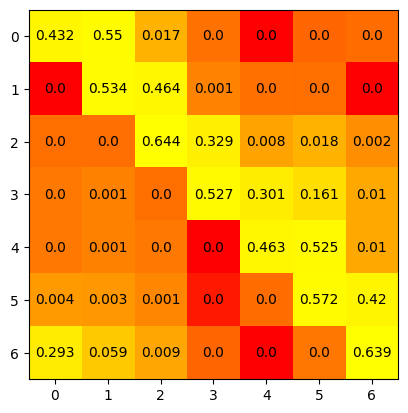

In [13]:
plot_matrix(model.transmat_)

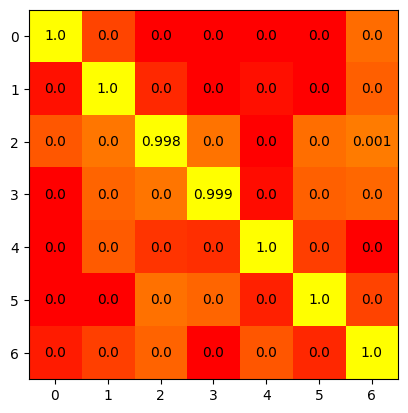

In [14]:
plot_matrix(model.emissionprob_)

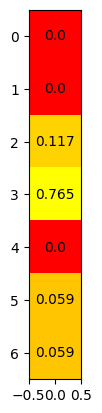

In [15]:
plot_matrix(np.array([model.startprob_]).reshape((7,1)))

## Counting Laps

In [16]:
start = time()

tranlate_path = [0,1,2,3,4,5,6]

start_segment = list(model.startprob_).index(np.max(model.startprob_))
counts = []
half = 7//2

team_laps: dict[int, list[int]] = {}

for team in teams:
    _, path = model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[team["id"]]]]))
    path = list(map(lambda x: tranlate_path[x], path))
    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            if len(lap_times) > 0:
                lap_times.pop()
        prev = segment

    counts.append((team["name"], count))
    team_laps[team['id']] = lap_times

counts = sorted(counts, key=lambda x:x[1])

print(counts)
#print(team_laps)

labels = [l for l, _ in counts]
counts = [c for _, c in counts]

print(f'Took: {time() - start}')

[('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
Took: 0.12980437278747559


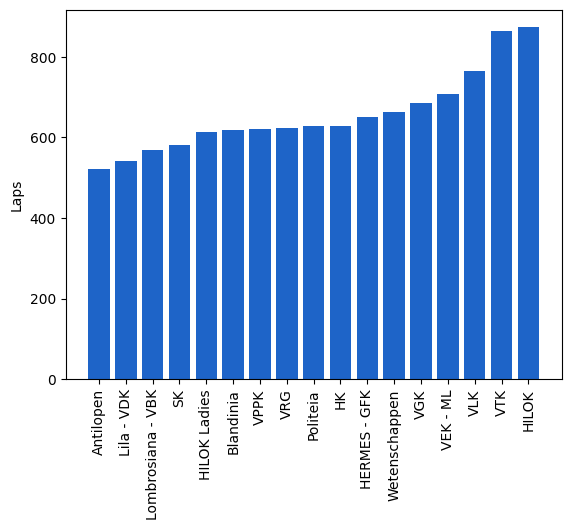

In [17]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts,  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Title
#plt.title("Laps per team")
plt.ylabel("Laps")
#plt.xlabel("Team")

# Show graphic
plt.show()

## Calculating difference

### Difference with total

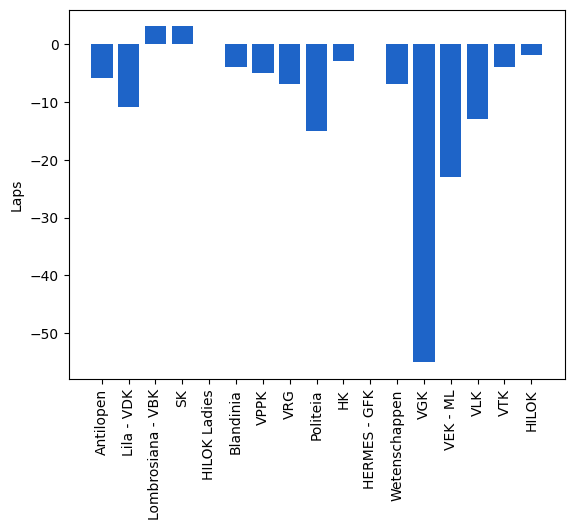

In [18]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}

# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values(),  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# axis
plt.ylabel("Laps")

# Show graphic
plt.show()

### Difference with viterbi last year

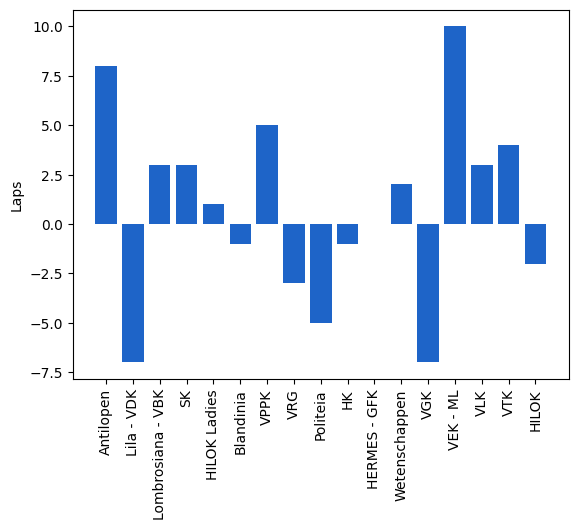

In [19]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# Only viterbi count - without manual data
urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}

own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}

# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values(),  color='#1E64C8')

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# axis
plt.ylabel("Laps")

# Show graphic
plt.show()

## Lap times

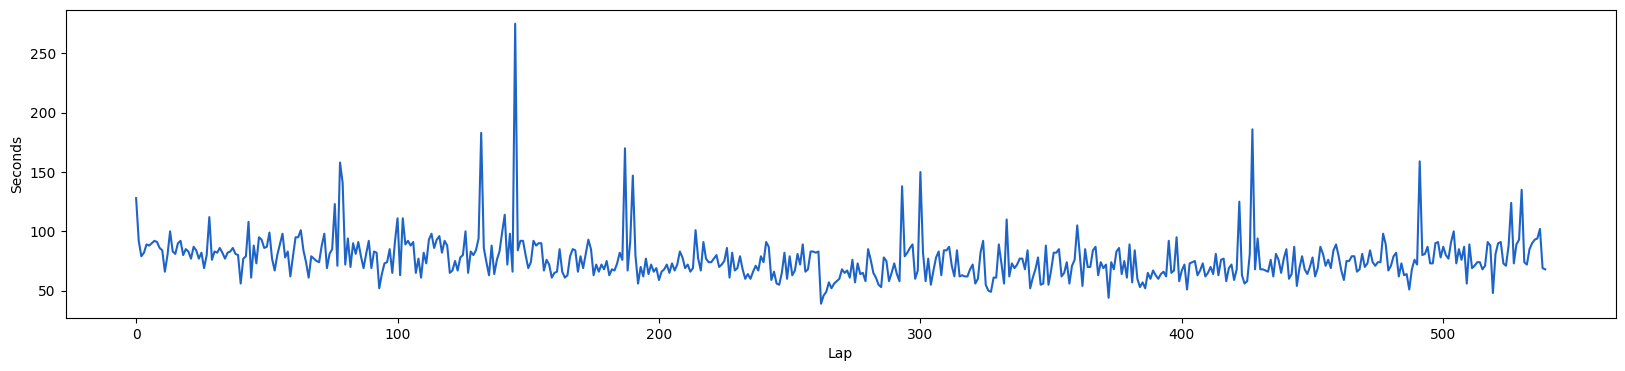

In [20]:
i = 9  # LILA - VDK
relative_laptimes = []
prev = team_laps[i][0]
for t in team_laps[i][1:-1]:
    relative_laptimes.append((t-prev)/1000)
    prev = t

plt.figure(figsize=(20, 4))
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.plot(np.array(relative_laptimes),color='#1E64C8')
plt.show()